# **Assignment 2**

For assignment 2, we provide an object detection model that uses R-CNN to predict swimming pool locations from satellite images, and the deep learning pipeline , which includes its architecture, trade-offs, and methods for avoiding overfitting. In R-CNN, we follow 4 steps:

1) Selectively search of image and generate a recommended region.

2) With ground truth data, calculate IOU (intersection over union) on proposed region and apply label to proposed areas.

3) Use the proposed regions with labels to perform transfer learning.

4) Submit the test image to selective search, then use the trained model to predict the class of the first 2000 recommended regions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/advanced-analytics/Assignment/Assignment2

/content/drive/MyDrive/advanced-analytics/Assignment/Assignment2


In [ ]:
!unzip "/content/drive/MyDrive/advanced-analytics/Assignment/Assignment2/data/images.zip"

#!rm images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/43.6198342_1.4740216.png  
  inflating: images/43.619917_1.4069512.png  
  inflating: images/43.6199228_1.4625883.png  
  inflating: images/43.6199673_1.4037257.png  
  inflating: images/43.6199683_1.471763.png  
  inflating: images/43.6200082_1.4609661.png  
  inflating: images/43.6200108_1.4606528.png  
  inflating: images/43.6200623_1.4596186.png  
  inflating: images/43.6200684_1.4138413.png  
  inflating: images/43.6200757_1.4137441.png  
  inflating: images/43.6200892_1.4523681.png  
  inflating: images/43.620104_1.4548037.png  
  inflating: images/43.6201234_1.4602113.png  
  inflating: images/43.6201332_1.4541244.png  
  inflating: images/43.6202266_1.4228669.png  
  inflating: images/43.6203196_1.4446524.png  
  inflating: images/43.6203767_1.4291393.png  
  inflating: images/43.6203858_1.4717425.png  
  inflating: images/43.6204035_1.4260167.png  
  inflating: images/43.6204103_1

In [ ]:
 #Packages 
import json
import pandas as pd
import numpy as np
import cv2
import random
#import sys
#!{sys.executable} -m pip install opencv-contrib-python
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import keras
from keras.metrics import Precision
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from matplotlib import pyplot as plt
from keras.layers import Dense,Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#Own .py-scripts
%run models_functions.py



In [ ]:
# Opening JSON file
f = open('data/metadata.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

df = pd.DataFrame.from_dict(data, orient='index')

In [ ]:
df.head()

,has_pool,center,bounds_lat_lon,bounds_x_y
42.7363609_2.8868181.png,True,"{'lat': 42.7363609, 'lon': 2.8868181}","[{'lat': 42.7364046, 'lon': 2.8867693}, {'lat'...","[{'x': 219.88854424638464, 'y': 197.9724640370..."
42.7008031_2.906998.png,True,"{'lat': 42.7008031, 'lon': 2.906998}","[{'lat': 42.700821, 'lon': 2.9069484}, {'lat':...","[{'x': 219.31757991040274, 'y': 223.9864984406..."
42.6892307_2.9110119.png,True,"{'lat': 42.6892307, 'lon': 2.9110119}","[{'lat': 42.6891823, 'lon': 2.9110157}, {'lat'...","[{'x': 258.80982304681845, 'y': 290.6887228406..."
44.5015552_0.1670612.png,True,"{'lat': 44.5015552, 'lon': 0.1670612}","[{'lat': 44.5015798, 'lon': 0.1670116}, {'lat'...","[{'x': 218.20287511855798, 'y': 215.7165834111..."
43.3741395_3.3383116.png,True,"{'lat': 43.3741395, 'lon': 3.3383116}","[{'lat': 43.3742033, 'lon': 3.3383698}, {'lat'...","[{'x': 299.5176070846709, 'y': 176.37075727338..."


In [ ]:
id = df.index

# 1 Data preprocessing 

# 1.1 Missing Values

Images that had no matching ID in the meta-dataset were removed. We can't deduce the polygon for the swimming pool (the ground truth box) from those images, thus we can't make predictions. After removing the missing Id, the dataset contains 14912 images instead of 14964. For all those the meta-data is available


In [ ]:

MissingID = []
for img_id in id :
    try:
        my_path ="images/" + img_id
        img = load_img(my_path)
    except:
           MissingID.append(img_id)
    

In [ ]:
# drop rows from provided list
df_clean = df[df.index.isin(MissingID) == False]

In [ ]:
df.shape

(14964, 4)

In [ ]:
df_clean.shape

(14912, 4)

In [ ]:
id = df_clean.index

In [ ]:
# Polygon corner points coordinates
pts = dict()

# Rectangle corner points coordinates
rect = dict()

xmax = dict()
xmin = dict()
ymax = dict()
ymin = dict()



In [ ]:
for img_id in id:
    x_list = []
    y_list = []
 
    list1 = data[img_id]['bounds_x_y']
    arr = np.empty((0,2), np.int32)
    for i in list1:
        arr = np.append(arr, [[i['x'],i['y']]], axis=0)
        x_list.append(i['x'])
        y_list.append(i['y'])
    xmax[img_id]= max(x_list)
    ymax[img_id]= max(y_list)
    xmin[img_id]= min(x_list)
    ymin[img_id]= min(y_list)
    
    height = ymax[img_id]- ymin[img_id]
    witdh = xmax[img_id] - xmin[img_id]
    arr_ = np.empty((0,2), np.int32)
    
    arr_ = np.append(arr_, [[xmax[img_id],ymax[img_id]]], axis=0)
    arr_ = np.append(arr_, [[xmax[img_id] - witdh ,ymax[img_id]]], axis=0)
    arr_ = np.append(arr_, [[xmax[img_id], ymax[img_id]-height]], axis=0)
    arr_ = np.append(arr_, [[xmax[img_id]- witdh,ymax[img_id]-height]], axis=0)
    rect[img_id] = arr_.reshape((-1, 1, 2))
    pts[img_id] = arr.reshape((-1, 1, 2))

In [ ]:
df_clean.head()

,has_pool,center,bounds_lat_lon,bounds_x_y
43.7291813_0.9148957.png,True,"{'lat': 43.7291813, 'lon': 0.9148957}","[{'lat': 43.7291879, 'lon': 0.9148306}, {'lat'...","[{'x': 207.0354838877101, 'y': 235.13030653197..."
43.7303081_0.9056727.png,True,"{'lat': 43.7303081, 'lon': 0.9056727}","[{'lat': 43.7302615, 'lon': 0.9056461}, {'lat'...","[{'x': 235.99261701359214, 'y': 290.5060027576..."
43.7308978_0.9088789.png,True,"{'lat': 43.7308978, 'lon': 0.9088789}","[{'lat': 43.7309208, 'lon': 0.9088155}, {'lat'...","[{'x': 208.3127604973891, 'y': 218.05878367421..."
43.7018647_1.061718.png,True,"{'lat': 43.7018647, 'lon': 1.061718}","[{'lat': 43.7018527, 'lon': 1.0616486}, {'lat'...","[{'x': 203.8250580548999, 'y': 254.47896743981..."
43.7009843_1.0365799.png,True,"{'lat': 43.7009843, 'lon': 1.0365799}","[{'lat': 43.7009784, 'lon': 1.0366376}, {'lat'...","[{'x': 299.3782412117028, 'y': 248.13531246571..."


From the following images we can see that some bounding boxes don't perfectly contain the target object. 

In [ ]:
for img_id in id[1:50]:
  try:
    x_min = xmin[img_id]
    x_max = xmax[img_id]
    y_min = ymin[img_id]
    y_max = ymax[img_id]
    pts_id = pts[img_id]
    plot_bbox(img_id,x_min,x_max,y_min,y_max,pts_id)

  except Exception as e:
            print(e)
            print("error in "+ img_id)
            continue


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# df.apply(some_func, args=('DOG', ), axis=1)
# df.apply(some_func, var1='DOG', axis=1)


In [ ]:
img_id = '42.6804_2.9496714.png'

my_path ='images/' + img_id
my_path
img = load_img(my_path)
x = img_to_array(img)
ImShape = x.copy()
ImShape2 = x.copy()

Polygon1 =Shape(pts[img_id])
Im1 =  DrawShape(ImShape, Polygon1, (255, 0, 0))

x_min = xmin[img_id]
x_max = xmax[img_id]
y_min = ymin[img_id]
y_max = ymax[img_id]
Im2 = Drawrect(ImShape2,x_min,x_max,y_min,y_max)

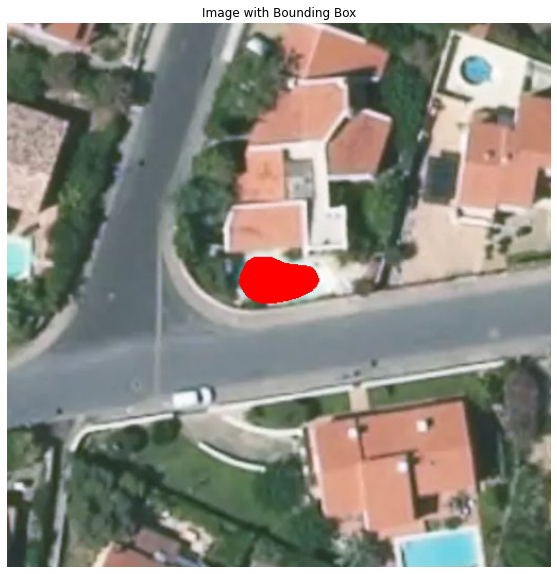

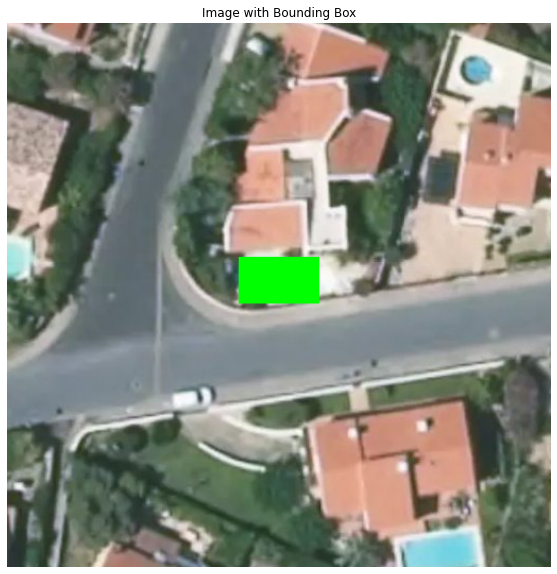

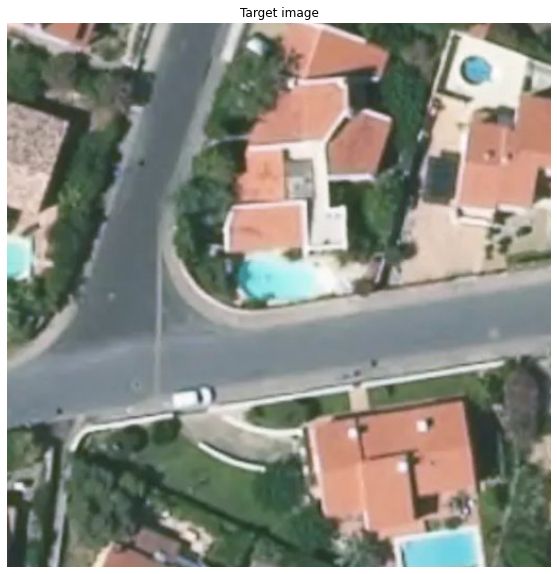

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(Im1.astype(np.uint32))
plt.axis("off")
plt.show()

plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(Im2.astype(np.uint32))
plt.axis("off")
plt.show()

plt.figure(figsize=(15,10))
plt.title('Target image')
plt.imshow(x.astype(np.uint32))
plt.axis("off")
plt.show()

In [ ]:
ImShape = x.copy()
# ImShape = cv2.cvtColor(ImShape,cv2.COLOR_BGR2GRAY)



In [ ]:
IntersectArea,OverlapIm,BoxArea,ShapeArea = Intersectarea_OverlapIm_BoxArea_ShapeArea(ImShape, Polygon1,x_min,y_min,x_max,y_max)
print('IntersectArea={}\n'.format(IntersectArea))

IntersectArea=2513



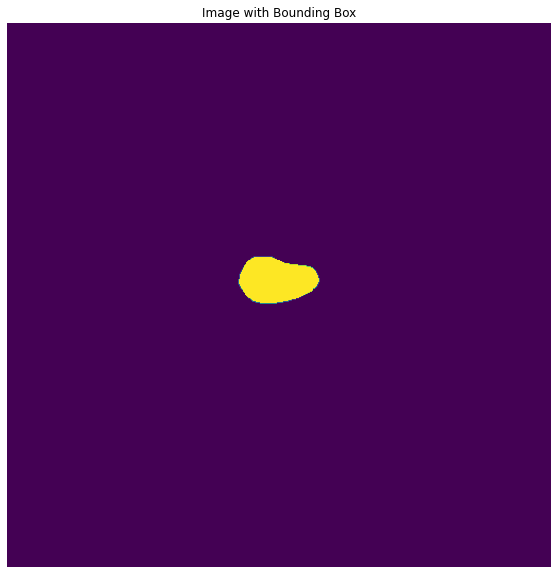

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(OverlapIm.astype(np.uint32))
plt.axis("off")
plt.show()

In [ ]:
get_iou(IntersectArea,BoxArea,ShapeArea)

0.8014670706426408

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
len(train_images)

0

## 1.2 Create new dataset

To run a selective search on the images, cv2 module needs to be imported. after that we can  start the selective search process.  We created a function to compute the ground truth box's IOU (Intersection Over Union) from the box obtained by selective search (predicted box).

A dataset is created that will be passed to the model. We can have two classes in this scenario. These classifications determine whether the suggested region is foreground (swimming pool)  or background. As a result, we'll set the foreground (swimming) label to 1 and the background label to 0. Instead of using all the images we only train the model on 1000 randomly chosen images because it computationally to expensive.

The following steps are being carried out:

1) Using the code "ss.setBase(x)", set an image as the base for selective search

2) Using the code "ss.switchToSelectiveSearchFast()" and "ssresults = ss.process()", we can initiate a fast selective search and receive proposed areas.

3) Iterate over all of the first 2000 results returned by selective search and calculate IOU for the proposed and annotated regions.

4) One image can contain many background samples and only a few foreground samples, we must ensure that we have a good proportion of both kind of samples when training our model. So we collect a maximum of 2 background and foreground samples from a single image.

In [ ]:
random.seed(321)
id2 = list(id)
random.shuffle(id2)

In [ ]:
for img_id in id2[0:1000]:
    try:
            my_path ='images/' + img_id 
            img = load_img(my_path)
            x = img_to_array(img)
            height, width, channel = x.shape
            ss.setBaseImage(x)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = x.copy()
            counter = 0
            falsecounter = 0
            fflag = 0
            bflag = 0
            Polygon1 = Shape(pts[img_id])

            for e,result in enumerate(ssresults):
                if e < 2000 :
                    x,y,w,h = result
                    IntersectArea,OverlapIm,BoxArea,ShapeArea=Intersectarea_OverlapIm_BoxArea_ShapeArea(imout, Polygon1,x,y,x+w,y+h)
                    if IntersectArea == 0:
                        continue
                    iou = get_iou(IntersectArea,BoxArea,ShapeArea)
                    
                    if counter < 2:
                        
                        if iou > 0.60:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        
                        fflag =1
                    if falsecounter <2:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1                       
                                
                if fflag == 1 and bflag == 1:
                    break                     
            
    except Exception as e:
            print(e)
            print("error in "+ img_id)
            continue


In [ ]:
len(train_images)

2816

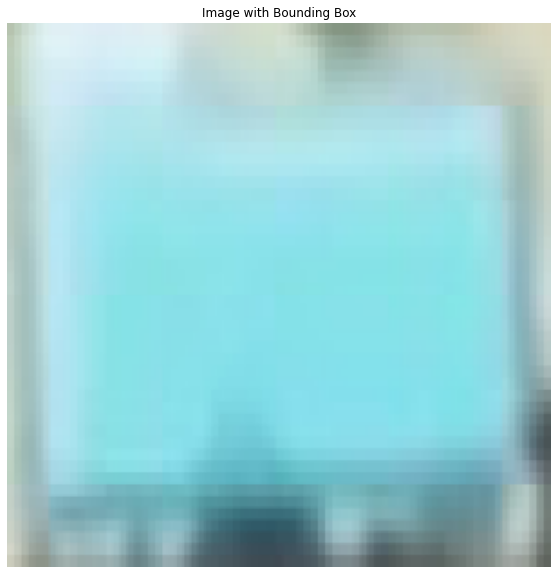

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(train_images[18].astype(np.uint32))
plt.axis("off")
plt.show()

In [ ]:
sum(train_labels)

816

# 2 Train,valid and test split

The list of arrays is converted to a list of numpy arrays so that it can be processed in an efficient way by the model. It is required to have a test set if we wish to evaluate our model's prediction power. In addition, we'd want to have a validation set so that we may enhance our model while it's being trained. As a result, we divided the data into three datasets: train, test, and validation But before that we need to one-hot encode the label. For that we are using "MyLabelBinarizer()" and encoding the dataset.

In [ ]:
X = np.array(train_images,dtype='uint8')
y= np.array(train_labels,dtype='uint8')

In [ ]:
lenc = MyLabelBinarizer()
y =  lenc.fit_transform(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.125, random_state=42, stratify=y)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.25,stratify=y_train,random_state=42)

In [ ]:
print(y.shape)
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')
print(X_val.shape, 'validation samples')


(2816, 2)
x_train shape: (1848, 224, 224, 3)
(1848, 224, 224, 3) train samples
(616, 224, 224, 3) test samples
(352, 224, 224, 3) validation samples


In [ ]:
X_train = X_train.astype(np.uint8)

In [ ]:
X_train.dtype

dtype('uint8')

In [ ]:
y_train = y_train.astype(np.uint8)

In [ ]:
X_val = X_val.astype(np.uint8)

In [ ]:
y_val = y_val.astype(np.uint8)

# 3 Model Architecture

We will now do transfer learning on the imagenet weight. We'll start by importing the VGG16 model and then adding the imagenet weight. The first 15 layers of the model are frozen. As a result, we'll be able to replicate the weights and architecture and adjust them to our liking. We also add some custom layers, such as a flat layer, a dense layer with relu activation and a kernel initializer='he uniform,' and a second dense layer with relu activation. Finally, the output layer must be adjusted to match the labels we want to predict. To the second final layer, a 2 unit sigmoid dense layer is added. Because we're dealing with a binary problem.
The model is then compiled using Adam optimizer with a learning rate of 0.001. We use binary_ crossentropy as a loss function and accuracy as a measure because the model's output is binary.

We'll now pass the dataset to the model, using "Keras ImageDataGenerator" the dataset is expanded. The following augmentations are performed; horizontal shift,vertical shift,width shift, height shift,horizontal flipping, vertical flipping, zoom range and rotation.
The rotation change option rotates the image 90 degrees clockwise at random. The horizontal and vertical shift ranges are controlled by the width shift range and height shift range arguments. The horizontal flip and vertical flip arguments are both set to 'True,' reversing the columns and rows of pixels, respectively. Zoom in and out of objects using the zoom range option. The batch size determines how many images are returned from the generator for each call.
To avoid overfitting, we built up an EarlyStopping based on the validation loss. If the fit does not alter after three epochs, it will be automatically stopped. To begin training the model, we'll use fit generator. We'll go on to the following step after we've done building the model, which is to make predictions based on it.

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=False, input_shape= (224,224,3))
vggmodel.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
base_model = Model(vggmodel.input,vggmodel.get_layer("block5_pool").output) # Gets all layers until block5_pool

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:


base_out = base_model.output
top_fc0 = Flatten()(base_out)
top_fc1 = Dense(4096,activation='relu',kernel_initializer='he_uniform')(top_fc0)
top_fc2 = Dense(4096,activation='relu')(top_fc1)
top_preds = Dense(2,activation = 'sigmoid')(top_fc2)
model = Model(base_model.input,top_preds)
model.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=['accuracy',Precision(),AUC()])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
data_augmentation = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2, horizontal_flip = True, vertical_flip=True, zoom_range=0.3)
train_data = data_augmentation.flow(X_train,y_train,batch_size = 64)
val_data = data_augmentation.flow(X_val,y_val,batch_size = 64)



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
modelCheckpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

In [ ]:
h_callback =  model.fit_generator(train_data,epochs =100, steps_per_epoch = len(train_data), 
                                      validation_steps = len(val_data ),callbacks = [early_stopping,modelCheckpoint],
                                      validation_data = val_data, verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
29/29 [==============================] - 27s 943ms/step - loss: 0.0833 - accuracy: 0.9724 - precision: 0.9724 - auc: 0.9950 - val_loss: 0.1347 - val_accuracy: 0.9432 - val_precision: 0.9460 - val_auc: 0.9897
Epoch 2/100
29/29 [==============================] - 27s 919ms/step - loss: 0.0834 - accuracy: 0.9708 - precision: 0.9692 - auc: 0.9954 - val_loss: 0.1099 - val_accuracy: 0.9716 - val_precision: 0.9744 - val_auc: 0.9912
Epoch 3/100
29/29 [==============================] - 26s 904ms/step - loss: 0.0886 - accuracy: 0.9697 - precision: 0.9697 - auc: 0.9946 - val_loss: 0.1605 - val_accuracy: 0.9290 - val_precision: 0.9288 - val_auc: 0.9855
Epoch 4/100
29/29 [==============================] - 27s 915ms/step - loss: 0.0841 - accuracy: 0.9659 - precision: 0.9664 - auc: 0.9948 - val_loss: 0.1291 - val_accuracy: 0.9602 - val_precision: 0.9602 - val_auc: 0.9886
Epoch 5/100
29/29 [==============================] - 26s 905ms/step - loss: 0.0943 - accuracy: 0.9686 - precision: 0.967

In [ ]:
model.evaluate(X_train,y_train)

58/58 [==============================] - 9s 162ms/step - loss: 0.0764 - accuracy: 0.9708 - precision: 0.9714 - auc: 0.9964


[0.07635712623596191,
 0.9707792401313782,
 0.9713513255119324,
 0.9964072704315186]

In [ ]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 3s 159ms/step - loss: 0.1247 - accuracy: 0.9578 - precision: 0.9578 - auc: 0.9902


[0.12471872568130493,
 0.9577922224998474,
 0.9577922224998474,
 0.9902374148368835]

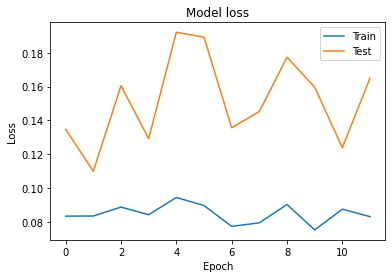

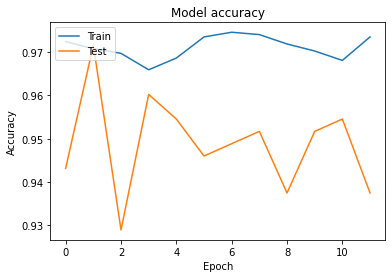

In [ ]:
# Plot train vs test loss during training
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

## Predictions

Predictions of the model based on a test image, pass the image as argument for the selective search and the
model.predict(img)  is used to pass all of the results of the selective search to the model as input .
Create a bounding box on the original image on the coordinates of the proposed region if the model output states the region is a foreground (swimming pool) and the confidence is over the defined threshold. The model has trouble detecting a swimming pool without water, which could be due to the small training set size. In a subsequent try, we should expand the training set size.

In [ ]:
for i in [2000,3000,4000,5000,6000]:
  my_path ='images/' + id2[i] 
  img = load_img(my_path)
  x = img_to_array(img)
  height, width, channel = x.shape
  ss.setBaseImage(x)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = x.copy()

  for e,result in enumerate(ssresults):
    if e < 2000:
      x,y,w,h = result
      timage = imout[y:y+h,x:x+w]
      resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis=0)
      out= model.predict(img)
      if out[0][0] > 0.90:
        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(imout.astype(np.uint32))
  plt.axis("off")
  plt.show()


        

Output hidden; open in https://colab.research.google.com to view.